# APS PMDI canister fluorescence

Post processing of X-ray canister fluorescence data with KI and BaSO4.
Third step - take collated scans and use model developed previously to perform signal trapping corrections.
Depends on geometry and position.

Data collected by Daniel Duke, Lingzhe Rao & Alan Kastengren
@ Advanced Photon Source, Argonne National Laboratory, Lemont, Illinois USA
November, 2022.

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2022 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 26/02/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Experimental parameters

The angle of the detector is approximately 67 degrees with respect to the beam according to Roger's photo.

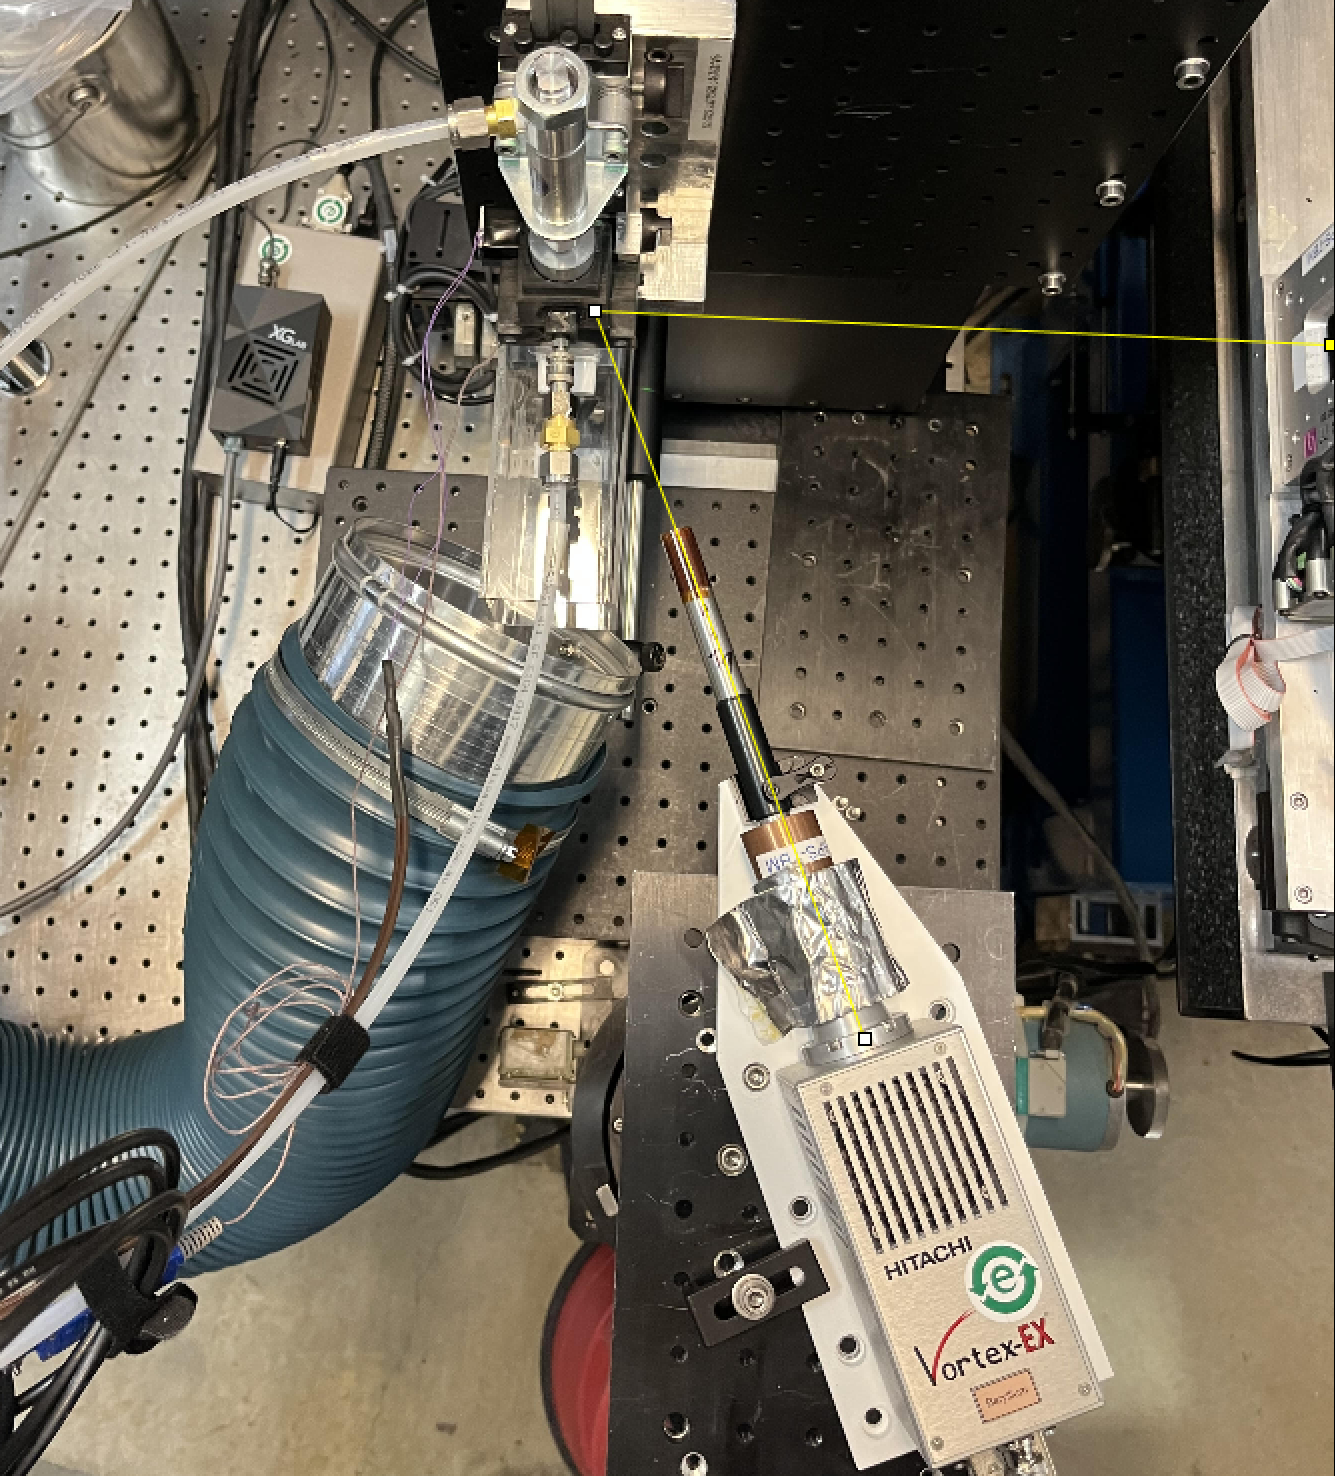

In [30]:
import h5py
import numpy as np
import scipy.optimize, scipy.integrate, scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

# Get my functions from the last notebook, which are saved into a Python module.
from dd_xrf_functions import *

In [3]:
def yTransform(y):
    '''
        Convert the raw beamline Y position to a useful coordinate
        (relative to the valve height).
        
        This was determined based on the dummy scans of an empty can, from the previous notebook
    '''
    return 75-y

## 1. Load an example file with some horizontal scans

First, let's view some uncorrected raw data.

<IPython.core.display.Javascript object>


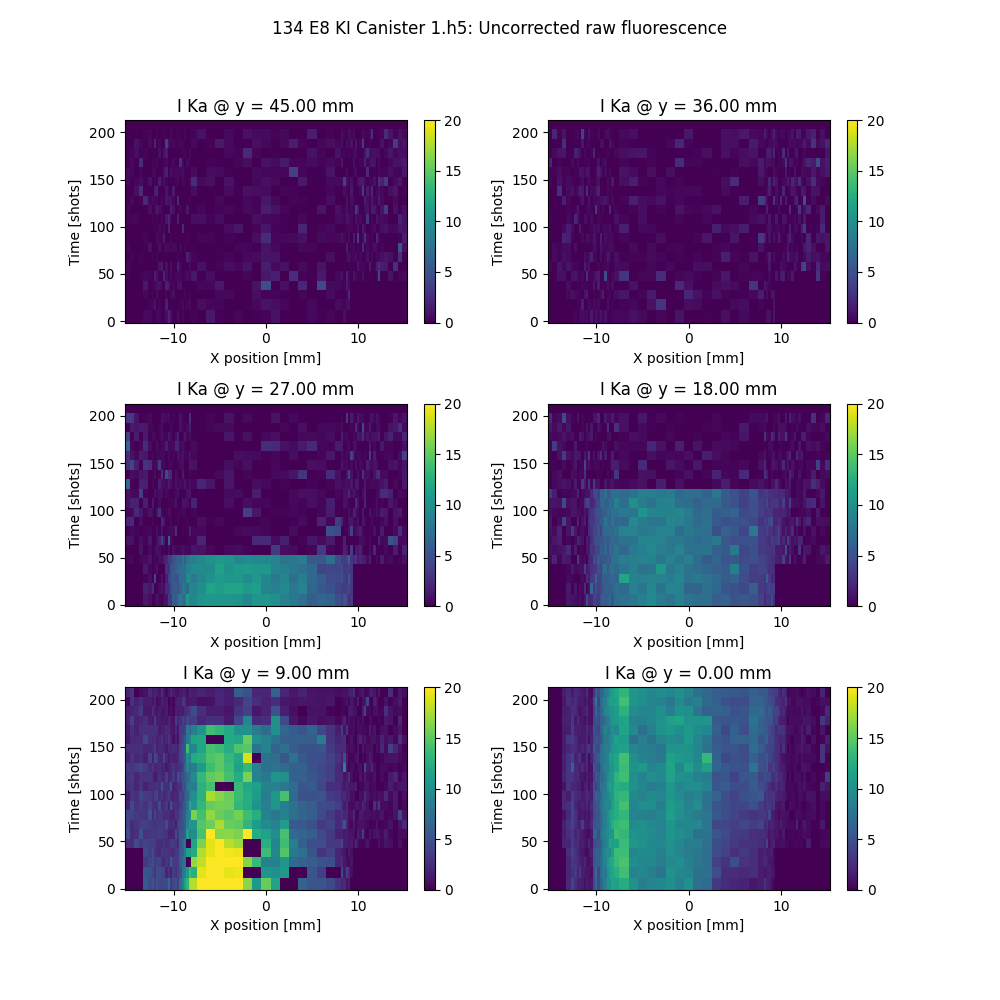

<IPython.core.display.Javascript object>


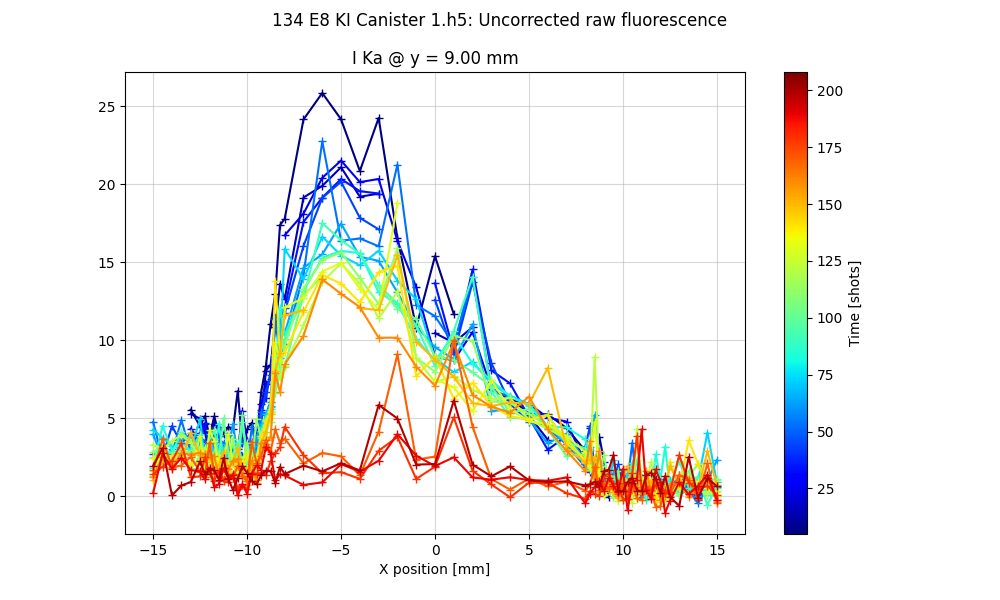

In [31]:
for filename in ["134 E8 KI Canister 1.h5"]:
    
    with h5py.File(filename,'r') as H:
        
        x,y,t,zF = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/I Ka/integral'] )
    
        # Outlier masking
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                dz = np.diff(zF[...,i,j]) #/np.diff(x[...,i,j])
                dz = np.hstack((0, dz))
                zF[np.abs(dz)>10,i,j] = np.nan
                
    
        # Plot surfaces of x,t for each y
        fig=plt.figure(figsize=(10,10))
        plt.suptitle("%s: Uncorrected raw fluorescence" % filename)
        for i in range(x.shape[1]):
            ym = np.nanmean(y[:,i,:])
            ax=fig.add_subplot(3,int(x.shape[1]/3),i+1)
            plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
            plt.xlabel('X position [mm]'); plt.ylabel('Time [shots]')
            ph=ax.pcolormesh(x[:,i,:],t[:,i,:],np.nan_to_num(zF[:,i,:]),vmin=0,vmax=20)
            plt.colorbar(ph)
        plt.subplots_adjust(hspace=.4)

        # For a particularly useful position, show some line-plots
        i=4
        ym = np.nanmean(y[:,i,:])
        fig=plt.figure(figsize=(10,6))
        plt.suptitle("%s: Uncorrected raw fluorescence" % filename)
        plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
        plt.grid(alpha=.5)
        for j in range(x.shape[2]): # loop time
            plt.plot(x[:,i,j],zF[:,i,j],marker='+',c=plt.cm.jet(j/float(t.shape[2])))
        plt.xlabel('X position [mm]')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
        plt.colorbar(sm,ax=plt.gca(),label='Time [shots]')
    

The plot above shows a definite skew to the left hand side, which is almost certainly due to signal-trapping.

## 2. Apply signal trapping corrections to data

Using functions imported from previous notebook.

In [34]:
def applySignalTrapping(x_All,y_All,fluor_All,pin_All):
    '''
        Apply signal trapping corrections in the x,z plane. Assuming a cylindrical canister and uniform external environment
        with a uniform internal liquid density (but nonuniform fluorescing tracer concentration possible).
        
        Can handle n-dimensional array data by flattening everything and assessing each sample one at a time.
    '''
        
    # Constants determined by fitting to empty canister data.
    x0=0                 # x-alignment of center of the canister.
    thkCan=0.706982      # canister wall thickness [mm]
    muCan=1.732022       # attenuation/rho of the canister wall at incident beam energy [1/cm]
    muExt=0.455318       # attenuation/rho of the external components 
    
    # Functions that depend on y.
    thkExtGradient = lambda y: 0.2   # attenuation gradient in x of the external environment [1/cm/mm]
    thkExtConst = lambda y: 60       # attenuation average of the external environment [1/cm]
    ri = lambda y: 11                # canister inner wall radius
    riValve = lambda y: 0            # effective radius of the metering valve or canister dome part [mm]
    
    # X-ray constants
    
    # attenuation/rho of the liquid formulation at the incident energy [1/cm]
    muFluid = {'134':0.328336,'152':0.222837,'1234E':0.271999,'EtOH':0.186543}   

    # attenuation/rho of the fluorescing tracer at the incident energy [1/cm]
    muTracer  = {'I':19.4738,'Ba':12.933*137.327/233.38}
    
    # attenuation/rho of the liquid formulation at the emission energy [1/cm]
    muFluid_Ka  = {'I':{'134':0.572199,'152':0.364844,'1234E':0.464389,'EtOH':0.330578},\
                   'Ba':{'134':0.464644,'152':0.30246,'1234E':0.379642,'EtOH':0.289781}}
    
    # attenuation/rho of the canister wall at the emission energy [1/cm]
    muCan_Ka  = {'I':muCan * 3.4816/1.38491,'Ba':muCan * 2.54821/1.38491}
    
    # attenuation/rho of the air at the emission energy [1/cm]
    muAir_Ka  = {'I':0.0004244,'Ba':0.000359733}
    
    fluorYield = 0.85 # fluorescence yield for this edge
    
    # Detector constants
    rDet = 275.           # distance from canister axis to the detector
    thetaDet = 67*np.pi/180.           # angle of the detector with respect to the X axis of the scan.
    solidDet = np.pi*(15**2)/(rDet**2) # approximate solid angle of the detector relative to canister axis.
    
    # Setup arrays
    x = x_All.ravel()
    y = y_All.ravel()
    f = fluor_All.ravel()
    p = pin_All.ravel()
    correction = np.ones_like(x)
    
    # Loop each element in the matrix
    for i in range(len(x)):
        
        # Determine attenuation of incident beam in ext & wall, assuming z-symmetry.
        
        # Use pin data to estimate fluid density along path. Apply guardrails in case of noisy data!
        
        # Determine attenuation of incident beam at the point of emission.
        # Assume that everything in the liquid path contributes (no polycapillary)
        
        # Determine amount of emitted radiation in the solid angle.
        
        # Determine attenuation of emitted radiation through the liquid to the wall.
        
        # Determine attenuation of emitted radiation through the wall and exterior and air.
        
        # Generate the lumped constant for the signal trapping correction for all above effects.
    
        pass
    
    return correction.reshape(fluor_All.shape)

In [ ]:
for filename in ["134 E8 KI Canister 1.h5"]:
    
    with h5py.File(filename,'r') as H:
        
        x,y,t,zF = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/I Ka/integral'] )
        
        x,y,t,zP = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/pinDiode'] )

        x,y,t,I0 = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/diamondMonitor'] )

        zF_corr = applySignalTrapping(x,y,zF,-np.log(zP/I0))
    
    # For a particularly useful position, show some line-plots
    i=5
    ym = np.nanmean(y[:,i,:])
    
    fig=plt.figure(figsize=(10,6))
    plt.suptitle("%s: Uncorrected raw fluorescence" % filename)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.grid(alpha=.5)
    for j in range(x.shape[2]): # loop time
        plt.plot(x[:,i,j],np.nan_to_num(zF[:,i,j]),marker='+',c=plt.cm.jet(j/float(t.shape[2])))
    plt.xlabel('X position [mm]')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
    plt.colorbar(sm,ax=plt.gca(),label='Time [shots]')
    
    fig=plt.figure(figsize=(10,6))
    plt.suptitle("%s: Signal trapping" % filename)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.grid(alpha=.5)
    for j in range(x.shape[2]): # loop time
        plt.plot(x[:,i,j],np.nan_to_num(zF_corr[:,i,j]),marker='+',c=plt.cm.jet(j/float(t.shape[2])))
    plt.xlabel('X position [mm]')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
    plt.colorbar(sm,ax=plt.gca(),label='Time [shots]')
    